## CS 513 B - Knowledge Discovery and Data Mining
### FINAL PROJECT - CREDIT CARD FRAUD DETECTION
### GROUP 8 - Abraar Subhan, K Senthil Kumar, Navya Jonnala, Ritwik Kosi Reddy

In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, skew

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, MaxAbsScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier ,BaggingClassifier 
import xgboost as xgb
# import lightgbm as lgb

from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix, classification_report,roc_auc_score, precision_recall_fscore_support, roc_curve, auc, f1_score
from sklearn import metrics

from sklearn.datasets import make_classification


In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
df = pd.read_csv("CreditCardFraud_dataset.csv")
df.drop('Unnamed: 0',axis=1,inplace=True) 
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


## EDA

In [7]:
data=df

In [8]:
100*data.is_fraud.value_counts(normalize=True)

0    99.614014
1     0.385986
Name: is_fraud, dtype: float64

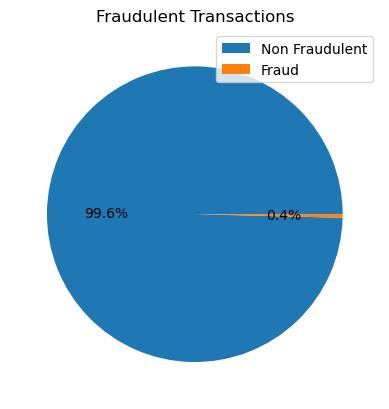

In [9]:
fraud_count = data.is_fraud.value_counts()
plt.pie(fraud_count, autopct='%1.1f%%')
plt.legend(['Non Fraudulent', 'Fraud'], loc="upper right")
plt.title('Fraudulent Transactions')
plt.show()

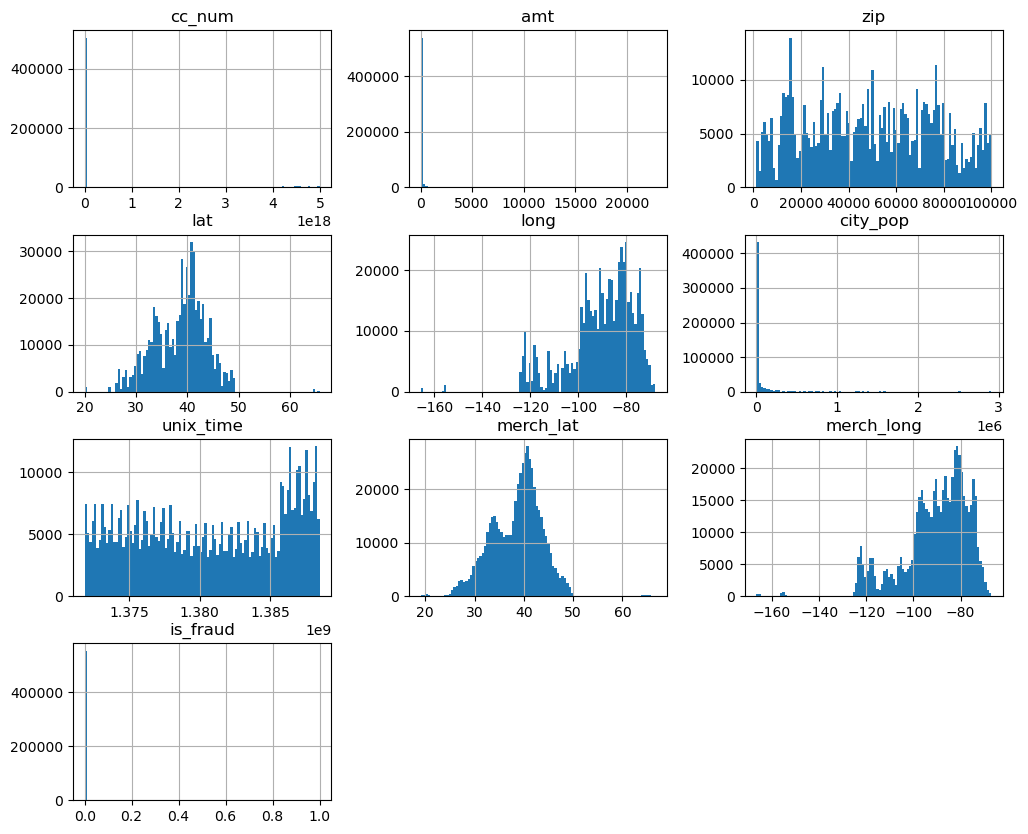

In [10]:
df.hist(bins=100, figsize=(12,10))
plt.show()

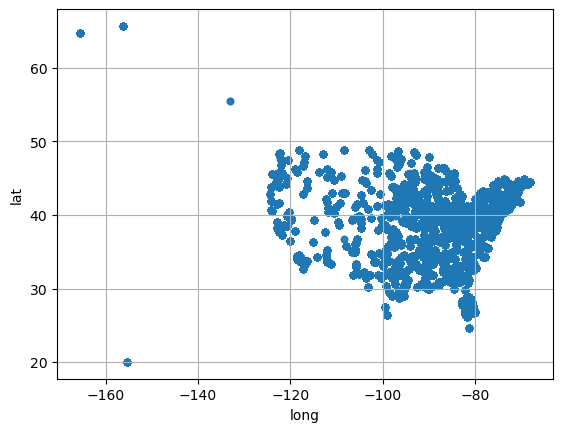

In [11]:
data.plot(kind="scatter", x = "long", y= "lat", grid=True, alpha = 0.2)
plt.show()

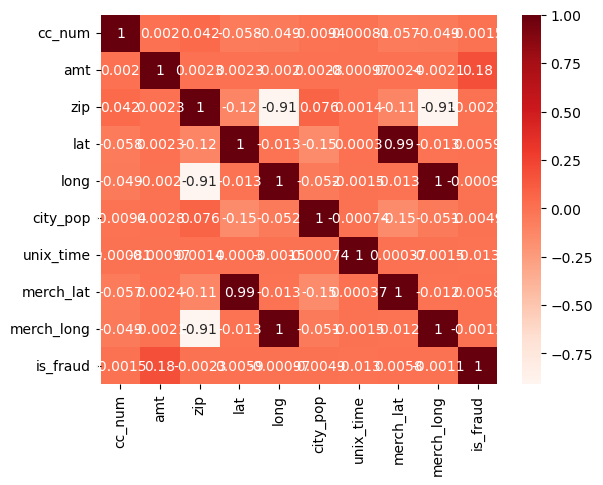

In [12]:
corr_matrix = data.corr()
corr_matrix["is_fraud"].sort_values(ascending = False)
dataplot = sns.heatmap(data.corr(), cmap="Reds", annot=True)

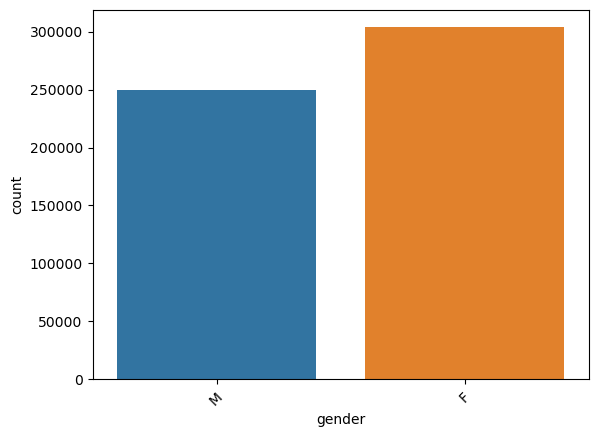

In [13]:
sns.countplot(data[data['is_fraud']==0].gender)
plt.xticks(rotation=45)
plt.show()

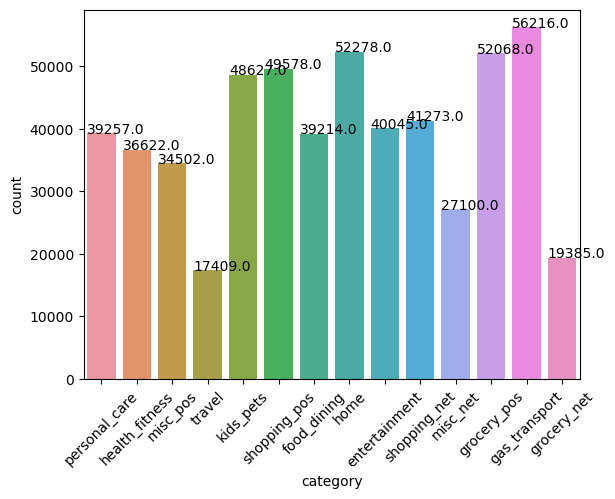

In [14]:
ax=sns.countplot(data[data['is_fraud']==0].category)
plt.xticks(rotation=45)
for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x(), p.get_height()+0.01))

plt.show()

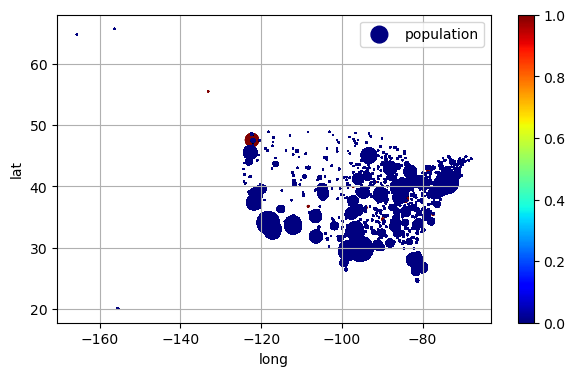

In [15]:
data.plot(kind = "scatter", x = "long", y= "lat", grid =  True, 
        s = data['city_pop']/10000, label = "population",
        c  =data.is_fraud, colormap="jet", colorbar=True,
        legend= True, sharex=False, figsize=(7,4))
plt.show()

In [16]:
testnum= data.select_dtypes(include=np.number)
data[testnum.columns]

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
0,2291163933867244,2.86,29209,33.9659,-80.9355,333497,1371816865,33.986391,-81.200714,0
1,3573030041201292,29.84,84002,40.3207,-110.4360,302,1371816873,39.450498,-109.960431,0
2,3598215285024754,41.28,11710,40.6729,-73.5365,34496,1371816893,40.495810,-74.196111,0
3,3591919803438423,60.05,32780,28.5697,-80.8191,54767,1371816915,28.812398,-80.883061,0
4,3526826139003047,3.19,49632,44.2529,-85.0170,1126,1371816917,44.959148,-85.884734,0
...,...,...,...,...,...,...,...,...,...,...
555714,30560609640617,43.77,63453,40.4931,-91.8912,519,1388534347,39.946837,-91.333331,0
555715,3556613125071656,111.84,77566,29.0393,-95.4401,28739,1388534349,29.661049,-96.186633,0
555716,6011724471098086,86.88,99323,46.1966,-118.9017,3684,1388534355,46.658340,-119.715054,0
555717,4079773899158,7.99,83643,44.6255,-116.4493,129,1388534364,44.470525,-117.080888,0


In [17]:
data.isnull().sum()

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

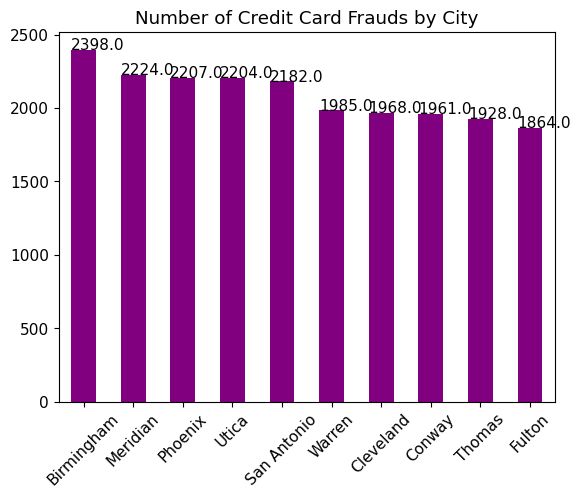

In [18]:
#Number of Credit Card Frauds by City

plt.rcParams.update({'font.size': 11})
ax = data[data['is_fraud']==0]["city"].value_counts(sort=True,ascending=False).head(10).plot(kind="bar",color="purple")
plt.xticks(rotation=45)
plt.title("Number of Credit Card Frauds by City")
for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x(), p.get_height()+0.01))
plt.show()

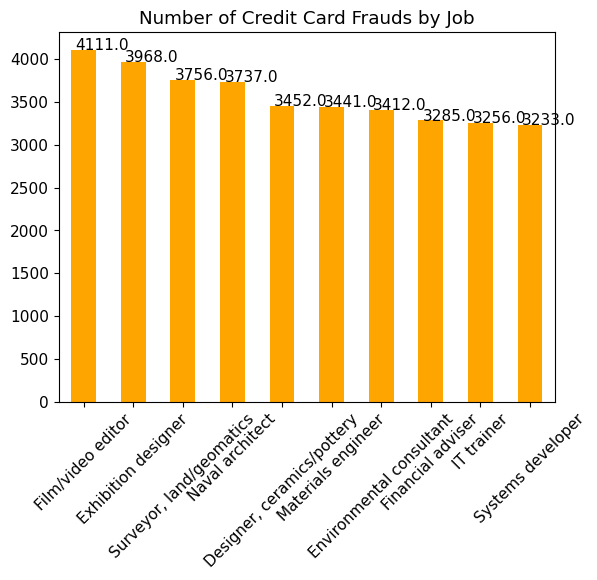

In [19]:
#Number of Credit Card Frauds by Job

plt.rcParams.update({'font.size': 11})
ax = data[data['is_fraud']==0]["job"].value_counts(sort=True,ascending=False).head(10).plot(kind="bar",color="orange")
plt.xticks(rotation=45)
plt.title("Number of Credit Card Frauds by Job")
for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+.09, p.get_height()+0.01))
plt.show()

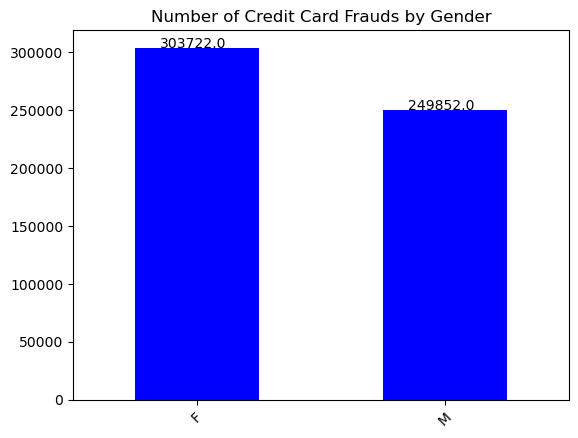

In [20]:
#Number of Credit Card Frauds by Gender

plt.rcParams.update({'font.size': 10})
ax = data[data['is_fraud']==0]["gender"].value_counts(sort=True,ascending=False).head(10).plot(kind="bar",color="blue")
plt.xticks(rotation=45)
plt.title("Number of Credit Card Frauds by Gender")
for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+.1, p.get_height()+0.01))
plt.show()

In [21]:
data['latitudinal_distance'] = abs(round(data['merch_lat']-data['lat'],3))
data['longitudinal_distance'] = abs(round(data['merch_long']-data['long'],3))

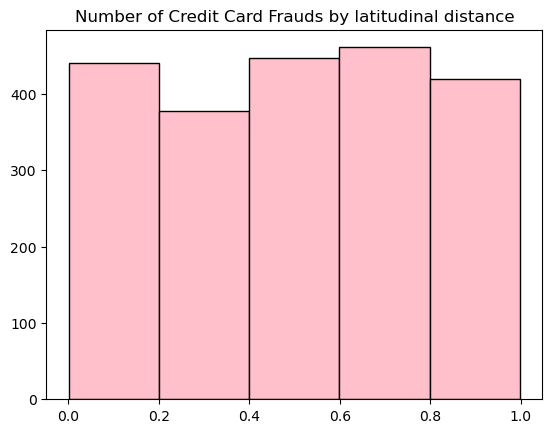

In [22]:
#Number of Credit Card Frauds by Latitudinal distance

fraud = data[data["is_fraud"]==1]
fig, ax = plt.subplots()
ax.hist(fraud.latitudinal_distance, edgecolor = "black", bins = 5, color="pink")
plt.title("Number of Credit Card Frauds by latitudinal distance")
plt.show()

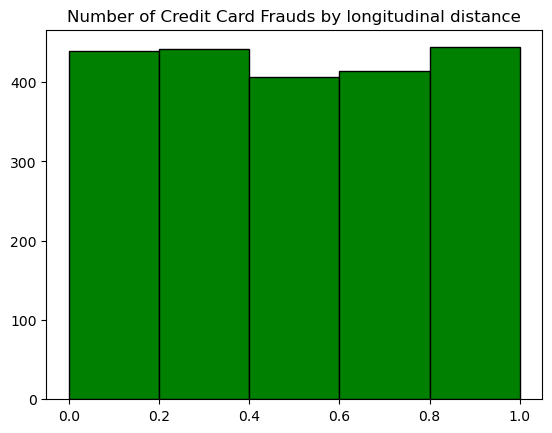

In [23]:
#Number of Credit Card Frauds by Longitudinal distance

fraud = data[data["is_fraud"]==1]
fig, ax = plt.subplots()
ax.hist(fraud.longitudinal_distance, edgecolor = "black", bins = 5, color="green")
plt.title("Number of Credit Card Frauds by longitudinal distance")
plt.show()

In [24]:
data['trans_date_trans_time']=pd.to_datetime(data['trans_date_trans_time'])
data['trans_date']=data['trans_date_trans_time'].dt.strftime('%Y-%m-%d')
data['trans_date']=pd.to_datetime(data['trans_date'])

In [25]:
data["trans_date"] = pd.to_datetime(data["trans_date"])
data["dob"] = pd.to_datetime(data["dob"])
data["age"] = data["trans_date"] - data["dob"]
data["age"] = data["age"].astype('timedelta64[Y]')


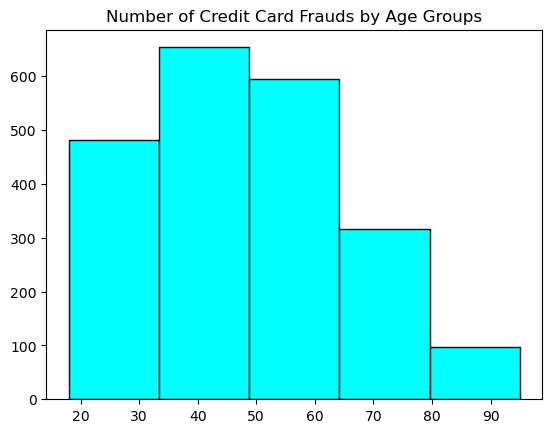

In [26]:
fraud=data[data["is_fraud"]==1]
fig, ax = plt.subplots()
ax.hist(fraud.age, edgecolor = "black", bins = 5, color="aqua")
plt.title("Number of Credit Card Frauds by Age Groups")
plt.show()

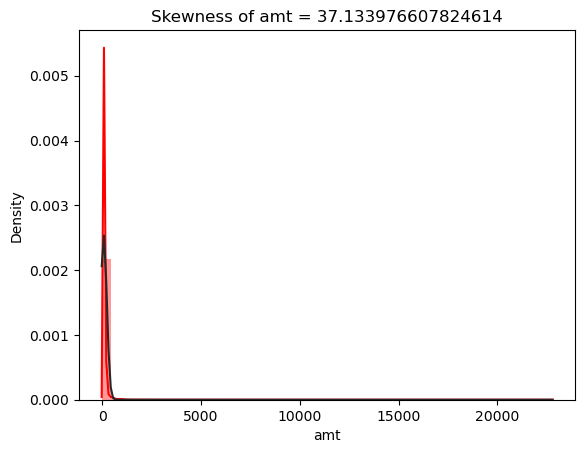

In [27]:
#Skewness of Amount
plt.rcParams.update({'font.size': 10})
skewness = str(skew(data['amt']))
sns.distplot(data['amt'],fit = norm,color = 'red')
plt.title("Skewness of amt"+" = "+skewness)
plt.show()

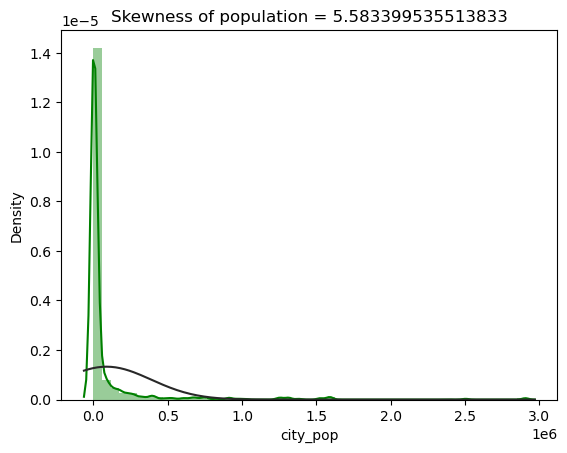

In [28]:
#Skewness of population
skewness = str(skew(data['city_pop']))
sns.distplot(data['city_pop'],fit = norm,color = "green")
plt.title("Skewness of population"+" = "+skewness)
plt.show()

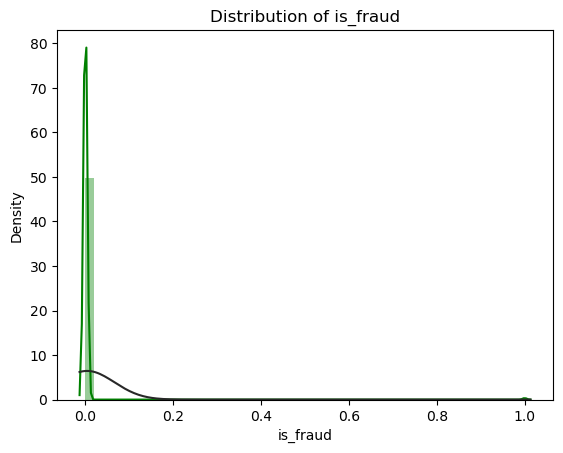

In [29]:
sns.distplot(data['is_fraud'],fit = norm,color = "green")
plt.title("Distribution of is_fraud")
plt.show()

In [30]:
#creating transacation month and transaction year columns
data['trans_month'] = pd.DatetimeIndex(data['trans_date']).month
data['trans_year'] = pd.DatetimeIndex(data['trans_date']).year
import calendar
data['Month_name'] = data['trans_month'].apply(lambda x: calendar.month_abbr[x])

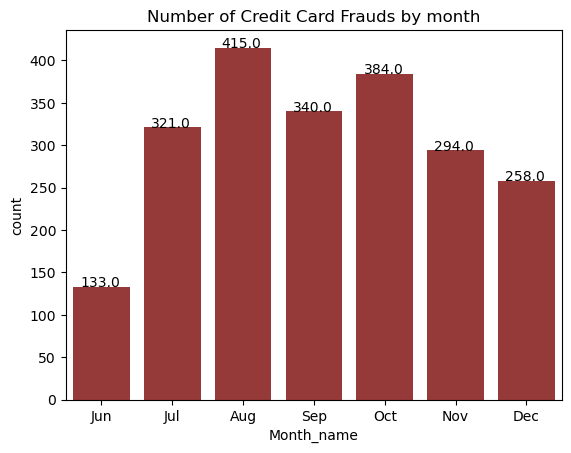

In [31]:
ax = sns.countplot(data[data["is_fraud"]==1]["Month_name"],color="brown")
plt.title("Number of Credit Card Frauds by month")
for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+.1, p.get_height()+0.01))
plt.show()
del data['Month_name']

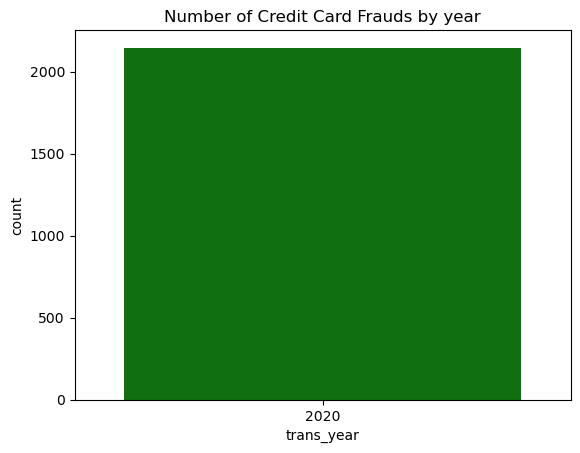

In [32]:
sns.countplot(data[data["is_fraud"]==1]["trans_year"],color="green")
plt.title("Number of Credit Card Frauds by year")
plt.show()

## DATA PRE PROCESSING

In [33]:
df = pd.read_csv('CreditCardFraud_dataset.csv') 
df.drop('Unnamed: 0',axis=1,inplace=True) 
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [34]:
pd.DataFrame(df.isnull().value_counts())

,,,,,,,,,,,,,,,,,,,,,,0
trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,
False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,555719


In [35]:
def gender_binarizer(x):
    if x=='F':
        return 1
    if x=='M':
        return 0
    
df['gender'] = df['gender'].transform(gender_binarizer)

In [36]:
df2 = df.loc[:,df.dtypes!=np.object]

In [37]:
X = df2.drop(['cc_num','is_fraud'],axis=1)
y = df2['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((389003, 9), (166716, 9), (389003,), (166716,))

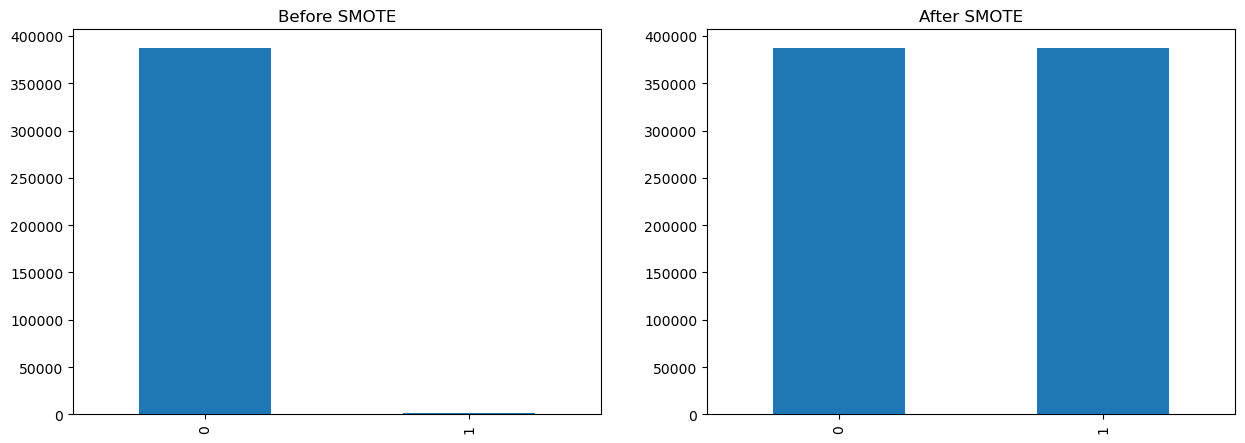

In [38]:
sm = SMOTE()
X_train_new, y_train_new = sm.fit_resample(X_train, y_train.ravel())

# to demonstrate the effect of SMOTE over imbalanced datasets
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize =(15, 5))
ax1.set_title('Before SMOTE')
pd.Series(y_train).value_counts().plot.bar(ax=ax1)

ax2.set_title('After SMOTE')  
pd.Series(y_train_new).value_counts().plot.bar(ax=ax2)

plt.show()

In [39]:
X_train, y_train = sm.fit_resample(X_train, y_train.ravel())
X_test, y_test = sm.fit_resample(X_test,y_test.ravel())

### Robust Scaler VS MinMaxScaler VS Standard Scaler

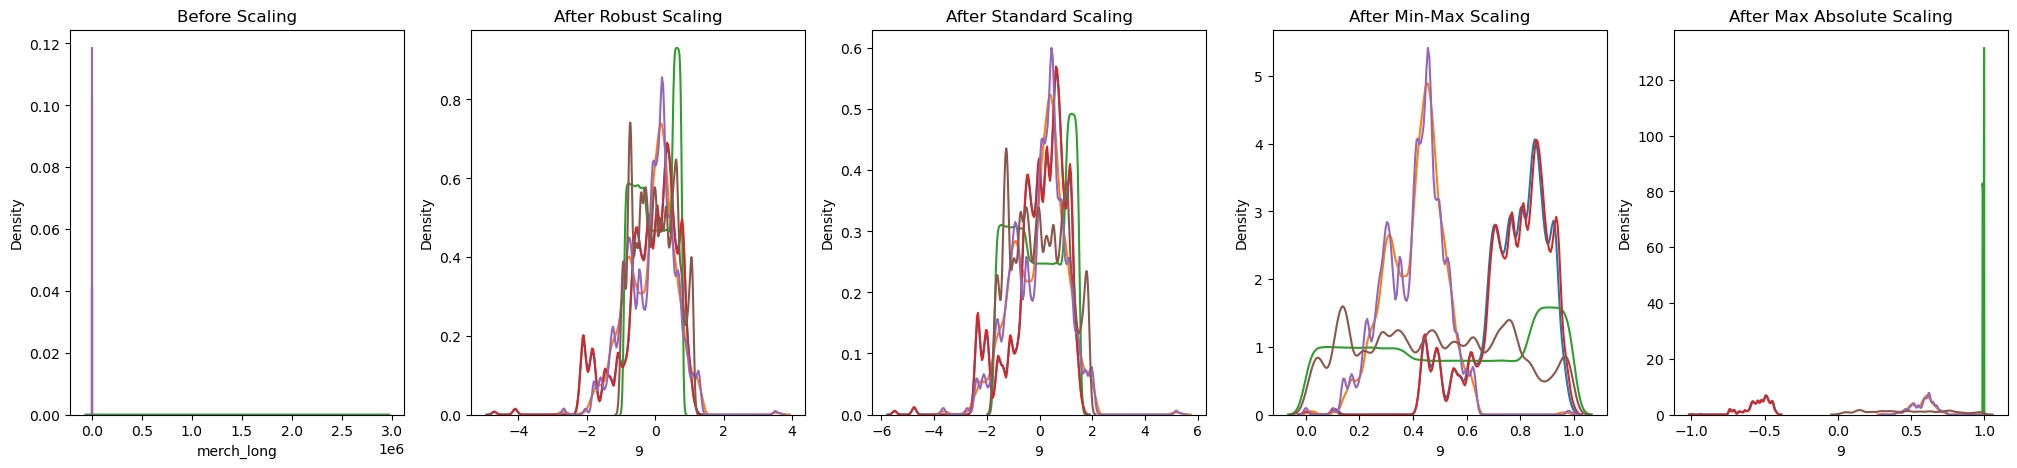

In [40]:
# to compare the effect of each scaler on our dataset
rob_scaler = RobustScaler()
robust_df = rob_scaler.fit_transform(df2)
robust_df = pd.DataFrame(robust_df)

std_scaler = StandardScaler()
standard_df = std_scaler.fit_transform(df2)
standard_df = pd.DataFrame(standard_df)

mm_scaler = MinMaxScaler()
minmax_df = mm_scaler.fit_transform(df2)
minmax_df = pd.DataFrame(minmax_df)

abs_scaler = MaxAbsScaler()
abs_df= abs_scaler.fit_transform(df2)
abs_df = pd.DataFrame(abs_df)


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(ncols =5, figsize =(25, 5))
ax1.set_title('Before Scaling')
sns.kdeplot(df2['merch_long'], ax = ax1)
sns.kdeplot(df2['merch_lat'], ax = ax1)
sns.kdeplot(df2['city_pop'], ax = ax1)
sns.kdeplot(df2['long'], ax = ax1)
sns.kdeplot(df2['lat'], ax = ax1)


ax2.set_title('After Robust Scaling')  
sns.kdeplot(robust_df[9], ax = ax2)
sns.kdeplot(robust_df[8], ax = ax2)
sns.kdeplot(robust_df[7], ax = ax2)
sns.kdeplot(robust_df[5], ax = ax2)
sns.kdeplot(robust_df[4], ax = ax2)
sns.kdeplot(robust_df[3], ax = ax2)


ax3.set_title('After Standard Scaling')  
sns.kdeplot(standard_df[9], ax = ax3)
sns.kdeplot(standard_df[8], ax = ax3)
sns.kdeplot(standard_df[7], ax = ax3)
sns.kdeplot(standard_df[5], ax = ax3)
sns.kdeplot(standard_df[4], ax = ax3)
sns.kdeplot(standard_df[3],ax=ax3)

ax4.set_title('After Min-Max Scaling')  
sns.kdeplot(minmax_df[9], ax = ax4)
sns.kdeplot(minmax_df[8], ax = ax4)
sns.kdeplot(minmax_df[7], ax = ax4)
sns.kdeplot(minmax_df[5], ax = ax4)
sns.kdeplot(minmax_df[4], ax = ax4)
sns.kdeplot(minmax_df[3], ax = ax4)

ax5.set_title('After Max Absolute Scaling')  
sns.kdeplot(abs_df[9], ax = ax5)
sns.kdeplot(abs_df[8], ax = ax5)
sns.kdeplot(abs_df[7], ax = ax5)
sns.kdeplot(abs_df[5], ax = ax5)
sns.kdeplot(abs_df[4], ax = ax5)
sns.kdeplot(abs_df[3], ax = ax5)


plt.show()

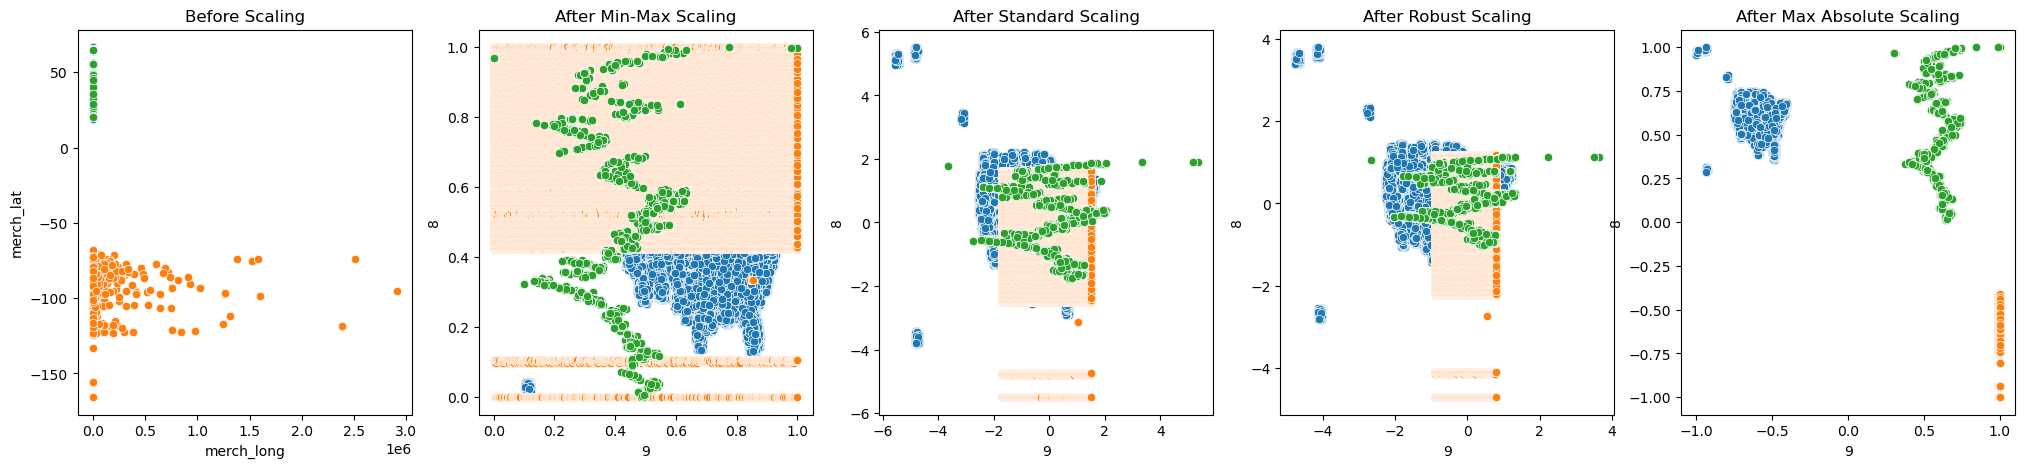

In [41]:
fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(ncols = 5, figsize =(25, 5))
ax1.set_title('Before Scaling')
sns.scatterplot(df2['merch_long'],df2['merch_lat'], ax = ax1)
sns.scatterplot(df2['city_pop'],df2['long'], ax = ax1)
sns.scatterplot(df2['lat'],df2['lat'], ax = ax1)


ax2.set_title('After Min-Max Scaling')  
scatter_ax = sns.scatterplot(minmax_df[9], minmax_df[8], ax=ax2)
scatter_ax = sns.scatterplot(minmax_df[7], minmax_df[5], ax=ax2)
scatter_ax = sns.scatterplot(minmax_df[4], minmax_df[3], ax=ax2)

ax3.set_title('After Standard Scaling')  
scatter_ax = sns.scatterplot(standard_df[9], standard_df[8], ax=ax3)
scatter_ax = sns.scatterplot(standard_df[7], standard_df[5], ax=ax3)
scatter_ax = sns.scatterplot(standard_df[4], standard_df[3], ax=ax3)

ax4.set_title('After Robust Scaling')  
scatter_ax = sns.scatterplot(robust_df[9], robust_df[8], ax=ax4)
scatter_ax = sns.scatterplot(robust_df[7], robust_df[5], ax=ax4)
scatter_ax = sns.scatterplot(robust_df[4], robust_df[3], ax=ax4)

ax5.set_title('After Max Absolute Scaling')
scatter_ax = sns.scatterplot(abs_df[9], abs_df[8], ax=ax5)
scatter_ax = sns.scatterplot(abs_df[7], abs_df[5], ax=ax5)
scatter_ax = sns.scatterplot(abs_df[4], abs_df[3], ax=ax5)

plt.show()

In [42]:
scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### ROC CURVE FUNCTION

In [43]:
def plot_roc_curve(y_test, preds):
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

---------------------------------------------------------------------------------
### MODEL IMPLEMENTATION
---------------------------------------------------------------------------------

### Adaboost

In [44]:
adab = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators=200)
adab.fit(X_train,y_train)
adab_pred = adab.predict(X_test)

_____________________________________________________________________________________________
ADABOOST CLASSIFIER:

_____________________________________________________________________________________________
The Accuracy score is:  89.96
The Precision score is:  93.72
The Recall score is:  85.66
The F1 score is:  89.51

The confusion matrix :
 [[156547   9529]
 [ 23823 142253]]


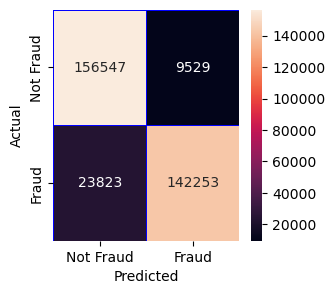


The ROC curve is :


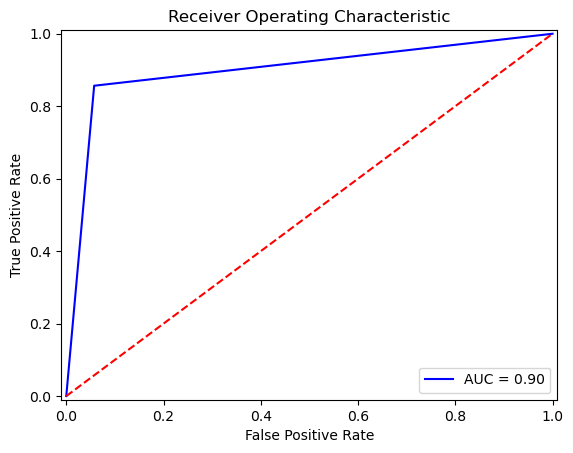

_____________________________________________________________________________________________


In [45]:
print('_____________________________________________________________________________________________')
print('ADABOOST CLASSIFIER:\n')
print('_____________________________________________________________________________________________')
print('The Accuracy score is: ',round(accuracy_score(y_test,adab_pred)*100,2))
print('The Precision score is: ',round(precision_score(y_test,adab_pred)*100,2))
print('The Recall score is: ',round(recall_score(y_test,adab_pred)*100,2))
print('The F1 score is: ',round(f1_score(y_test,adab_pred)*100,2))
print('\nThe confusion matrix :\n',confusion_matrix(y_test,adab_pred))

f, ax =plt.subplots(figsize = (3,3))

sns.heatmap(confusion_matrix(y_test,adab_pred),annot = True, linewidths= 0.5, linecolor="blue", fmt=".0f", ax=ax)
ax.xaxis.set_ticklabels(['Not Fraud', 'Fraud']); ax.yaxis.set_ticklabels(['Not Fraud', 'Fraud']);
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print('\nThe ROC curve is :')
plot_roc_curve(y_test,adab_pred)
print('_____________________________________________________________________________________________')

### DECISION TREE

In [46]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)
dtree_pred = dtree.predict(X_test)

_____________________________________________________________________________________________
DECISION TREE:

_____________________________________________________________________________________________
The Accuracy score is:  89.29
The Precision score is:  98.77
The Recall score is:  79.58
The F1 score is:  88.14

The confusion matrix :
 [[164430   1646]
 [ 33920 132156]]


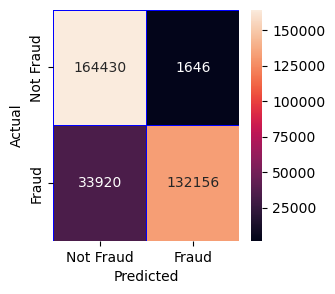


The ROC curve is :


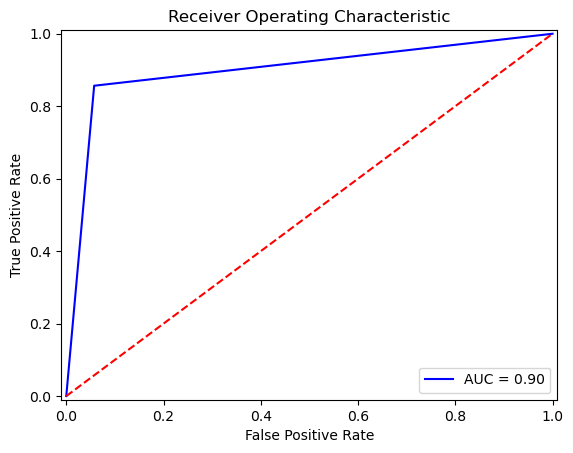

_____________________________________________________________________________________________


In [47]:
print('_____________________________________________________________________________________________')
print('DECISION TREE:\n')
print('_____________________________________________________________________________________________')
print('The Accuracy score is: ',round(accuracy_score(y_test,dtree_pred)*100,2))
print('The Precision score is: ',round(precision_score(y_test,dtree_pred)*100,2))
print('The Recall score is: ',round(recall_score(y_test,dtree_pred)*100,2))
print('The F1 score is: ',round(f1_score(y_test,dtree_pred)*100,2))
print('\nThe confusion matrix :\n',confusion_matrix(y_test,dtree_pred))

f, ax =plt.subplots(figsize = (3,3))

sns.heatmap(confusion_matrix(y_test,dtree_pred),annot = True, linewidths= 0.5, linecolor="blue", fmt=".0f", ax=ax)
ax.xaxis.set_ticklabels(['Not Fraud', 'Fraud']); ax.yaxis.set_ticklabels(['Not Fraud', 'Fraud']);
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print('\nThe ROC curve is :')
plot_roc_curve(y_test,adab_pred)
print('_____________________________________________________________________________________________')

### K-NEAREST NEIGHBOR

In [48]:
param_grid = {'n_neighbors': range(1,20)}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, verbose=3)
grid_search.fit(X_train, y_train)

best_knn = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'])
best_knn.fit(X_train, y_train)


Fitting 5 folds for each of 19 candidates, totalling 95 fits
[CV 1/5] END .....................n_neighbors=1;, score=0.996 total time=   5.4s
[CV 2/5] END .....................n_neighbors=1;, score=0.996 total time=   5.4s
[CV 3/5] END .....................n_neighbors=1;, score=0.996 total time=   5.3s
[CV 4/5] END .....................n_neighbors=1;, score=0.996 total time=   5.2s
[CV 5/5] END .....................n_neighbors=1;, score=0.996 total time=   5.1s
[CV 1/5] END .....................n_neighbors=2;, score=0.996 total time=   5.6s
[CV 2/5] END .....................n_neighbors=2;, score=0.996 total time=   5.6s
[CV 3/5] END .....................n_neighbors=2;, score=0.996 total time=   5.6s
[CV 4/5] END .....................n_neighbors=2;, score=0.996 total time=   5.6s
[CV 5/5] END .....................n_neighbors=2;, score=0.996 total time=   5.5s
[CV 1/5] END .....................n_neighbors=3;, score=0.994 total time=   5.8s
[CV 2/5] END .....................n_neighbors=3;

KNeighborsClassifier(n_neighbors=1)

In [49]:
knn_pred = best_knn.predict(X_test)

_____________________________________________________________________________________________
K NEAREST NEIGHBORS (KNN) :

_____________________________________________________________________________________________
The Accuracy score is:  91.33
The Precision score is:  99.17
The Recall score is:  83.36
The F1 score is:  90.58

The confusion matrix :
 [[164922   1154]
 [ 27643 138433]]


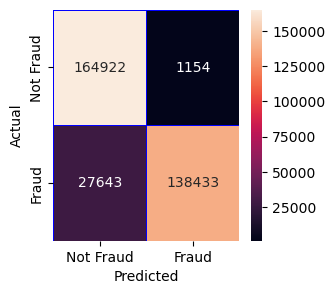


The ROC curve is :


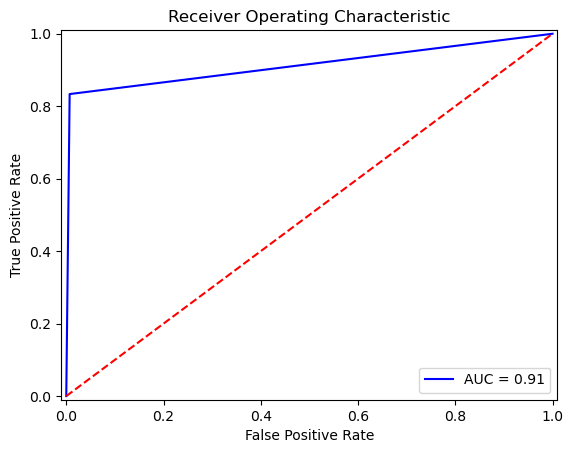

_____________________________________________________________________________________________


In [50]:
print('_____________________________________________________________________________________________')
print('K NEAREST NEIGHBORS (KNN) :\n')
print('_____________________________________________________________________________________________')
print('The Accuracy score is: ',round(accuracy_score(y_test,knn_pred)*100,2))
print('The Precision score is: ',round(precision_score(y_test,knn_pred)*100,2))
print('The Recall score is: ',round(recall_score(y_test,knn_pred)*100,2))
print('The F1 score is: ',round(f1_score(y_test,knn_pred)*100,2))
print('\nThe confusion matrix :\n',confusion_matrix(y_test,knn_pred))

f, ax =plt.subplots(figsize = (3,3))

sns.heatmap(confusion_matrix(y_test,knn_pred),annot = True, linewidths= 0.5, linecolor="blue", fmt=".0f", ax=ax)
ax.xaxis.set_ticklabels(['Not Fraud', 'Fraud']); ax.yaxis.set_ticklabels(['Not Fraud', 'Fraud']);
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print('\nThe ROC curve is :')
plot_roc_curve(y_test,knn_pred)
print('_____________________________________________________________________________________________')

### GAUSSIAN NAIVE BAYES

In [51]:
gnb = GaussianNB()
gnb.fit(X_train,y_train)
gnb_pred = gnb.predict(X_test)

_____________________________________________________________________________________________
GAUSSIAN NAIVE BAYES :

_____________________________________________________________________________________________
The Accuracy score is:  87.3
The Precision score is:  97.07
The Recall score is:  76.93
The F1 score is:  85.83

The confusion matrix :
 [[162215   3861]
 [ 38311 127765]]


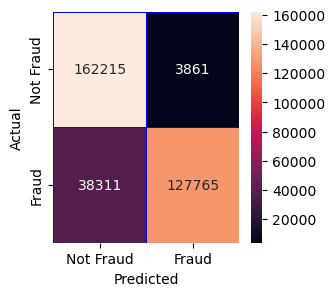


The ROC curve is :


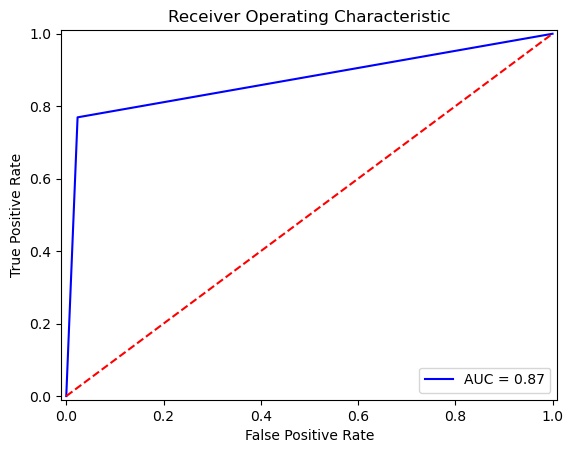

_____________________________________________________________________________________________


In [52]:
print('_____________________________________________________________________________________________')
print('GAUSSIAN NAIVE BAYES :\n')
print('_____________________________________________________________________________________________')
print('The Accuracy score is: ',round(accuracy_score(y_test,gnb_pred)*100,2))
print('The Precision score is: ',round(precision_score(y_test,gnb_pred)*100,2))
print('The Recall score is: ',round(recall_score(y_test,gnb_pred)*100,2))
print('The F1 score is: ',round(f1_score(y_test,gnb_pred)*100,2))
print('\nThe confusion matrix :\n',confusion_matrix(y_test,gnb_pred))

f, ax =plt.subplots(figsize = (3,3))

sns.heatmap(confusion_matrix(y_test,gnb_pred),annot = True, linewidths= 0.5, linecolor="blue", fmt=".0f", ax=ax)
ax.xaxis.set_ticklabels(['Not Fraud', 'Fraud']); ax.yaxis.set_ticklabels(['Not Fraud', 'Fraud']);
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print('\nThe ROC curve is :')
plot_roc_curve(y_test,gnb_pred)
print('_____________________________________________________________________________________________')

### XGBoost

In [53]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train, y_train)
xgb_y_pred = xgb_model.predict(X_test)

_____________________________________________________________________________________________
XG BOOST :

_____________________________________________________________________________________________
The Accuracy score is:  95.38
The Precision score is:  98.73
The Recall score is:  91.95
The F1 score is:  95.22

The confusion matrix :
 [[164119   1957]
 [ 13374 152702]]


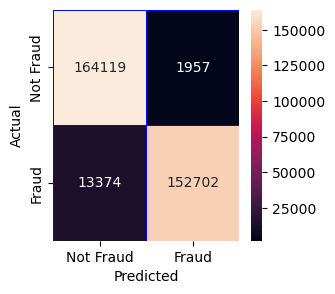


The ROC curve is :


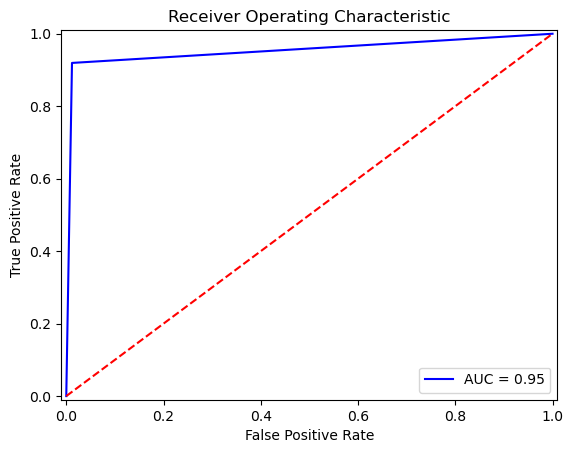

_____________________________________________________________________________________________


In [54]:
print('_____________________________________________________________________________________________')
print('XG BOOST :\n')
print('_____________________________________________________________________________________________')
print('The Accuracy score is: ',round(accuracy_score(y_test,xgb_y_pred)*100,2))
print('The Precision score is: ',round(precision_score(y_test,xgb_y_pred)*100,2))
print('The Recall score is: ',round(recall_score(y_test,xgb_y_pred)*100,2))
print('The F1 score is: ',round(f1_score(y_test,xgb_y_pred)*100,2))
print('\nThe confusion matrix :\n',confusion_matrix(y_test,xgb_y_pred))

f, ax =plt.subplots(figsize = (3,3))

sns.heatmap(confusion_matrix(y_test,xgb_y_pred),annot = True, linewidths= 0.5, linecolor="blue", fmt=".0f", ax=ax)
ax.xaxis.set_ticklabels(['Not Fraud', 'Fraud']); ax.yaxis.set_ticklabels(['Not Fraud', 'Fraud']);
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


print('\nThe ROC curve is :')
plot_roc_curve(y_test,xgb_y_pred)
print('_____________________________________________________________________________________________')

### LOGISTIC REGRESSION

In [55]:
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
}

lr = LogisticRegression(solver='lbfgs', random_state=0)
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
lr_y_pred = grid_search.best_estimator_.predict(X_test)

_____________________________________________________________________________________________
LOGISTIC REGRESSION :

_____________________________________________________________________________________________
The Accuracy score is:  88.76
The Precision score is:  94.47
The Recall score is:  82.33
The F1 score is:  87.99

The confusion matrix :
 [[158078   7998]
 [ 29340 136736]]


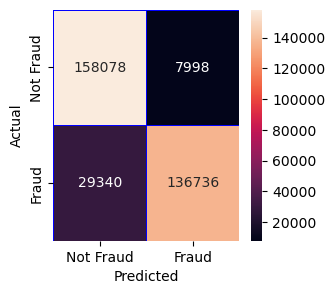


The ROC curve is :


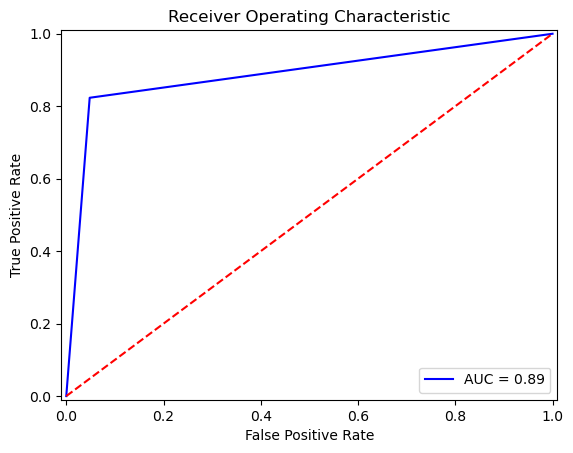

_____________________________________________________________________________________________


In [56]:
print('_____________________________________________________________________________________________')
print('LOGISTIC REGRESSION :\n')
print('_____________________________________________________________________________________________')
print('The Accuracy score is: ',round(accuracy_score(y_test,lr_y_pred)*100,2))
print('The Precision score is: ',round(precision_score(y_test,lr_y_pred)*100,2))
print('The Recall score is: ',round(recall_score(y_test,lr_y_pred)*100,2))
print('The F1 score is: ',round(f1_score(y_test,lr_y_pred)*100,2))
print('\nThe confusion matrix :\n',confusion_matrix(y_test,lr_y_pred))

f, ax =plt.subplots(figsize = (3,3))

sns.heatmap(confusion_matrix(y_test,lr_y_pred),annot = True, linewidths= 0.5, linecolor="blue", fmt=".0f", ax=ax)
ax.xaxis.set_ticklabels(['Not Fraud', 'Fraud']); ax.yaxis.set_ticklabels(['Not Fraud', 'Fraud']);
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print('\nThe ROC curve is :')
plot_roc_curve(y_test,lr_y_pred)
print('_____________________________________________________________________________________________')

### RANDOM FOREST

In [57]:
param_grid = {
    'n_estimators': [10, 20, 30],
    'max_depth': [2,4,6],

}

rlf = RandomForestClassifier(random_state=11)
random_search = RandomizedSearchCV(estimator=rlf,param_distributions=param_grid,n_iter=50,cv=5,random_state=11)
random_search.fit(X_train, y_train)
rlf_y_pred = random_search.best_estimator_.predict(X_test)

_____________________________________________________________________________________________
RANDOM FOREST :

_____________________________________________________________________________________________
The Accuracy score is:  89.61
The Precision score is:  95.7
The Recall score is:  82.94
The F1 score is:  88.86

The confusion matrix :
 [[159886   6190]
 [ 28336 137740]]


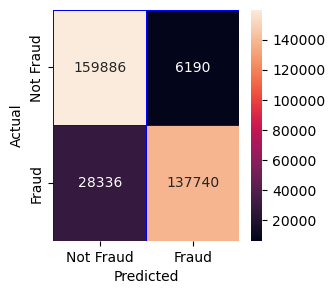


The ROC curve is :


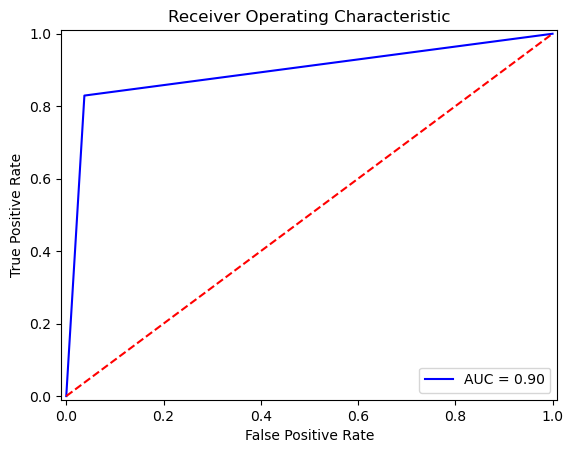

_____________________________________________________________________________________________


In [58]:
print('_____________________________________________________________________________________________')
print('RANDOM FOREST :\n')
print('_____________________________________________________________________________________________')
print('The Accuracy score is: ',round(accuracy_score(y_test,rlf_y_pred)*100,2))
print('The Precision score is: ',round(precision_score(y_test,rlf_y_pred)*100,2))
print('The Recall score is: ',round(recall_score(y_test,rlf_y_pred)*100,2))
print('The F1 score is: ',round(f1_score(y_test,rlf_y_pred)*100,2))
print('\nThe confusion matrix :\n',confusion_matrix(y_test,rlf_y_pred))

f, ax =plt.subplots(figsize = (3,3))

sns.heatmap(confusion_matrix(y_test,rlf_y_pred),annot = True, linewidths= 0.5, linecolor="blue", fmt=".0f", ax=ax)
ax.xaxis.set_ticklabels(['Not Fraud', 'Fraud']); ax.yaxis.set_ticklabels(['Not Fraud', 'Fraud']);
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print('\nThe ROC curve is :')
plot_roc_curve(y_test,rlf_y_pred)
print('_____________________________________________________________________________________________')

### SUPPORT VECTOR MACHINE

In [59]:
from sklearn import svm
df = pd.read_csv('CreditCardFraud_dataset.csv') 
df.drop('Unnamed: 0',axis=1,inplace=True) 

df['gender'] = df['gender'].transform(gender_binarizer)

df = df.loc[:,df.dtypes!=np.object]
s_df=df.sample(frac=0.03)


X = s_df.drop(['cc_num','is_fraud'],axis=1)
y = s_df['is_fraud']



X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_svm.shape, X_test_svm.shape, y_train_svm.shape, y_test_svm.shape

X_train_svm, y_train_svm = sm.fit_resample(X_train_svm, y_train_svm.ravel())
X_test_svm, y_test_svm = sm.fit_resample(X_test_svm,y_test_svm.ravel())
scaler = RobustScaler()

X_train_svm = scaler.fit_transform(X_train_svm)
X_test_svm = scaler.transform(X_test_svm)

_____________________________________________________________________________________________
SUPPORT VECTOR MACHINE :

_____________________________________________________________________________________________
The Accuracy score is:  86.64
The Precision score is:  96.63
The Recall score is:  75.93
The F1 score is:  85.04

The confusion matrix :
 [[4853  132]
 [1200 3785]]


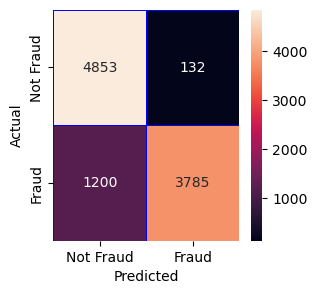


The ROC curve is :


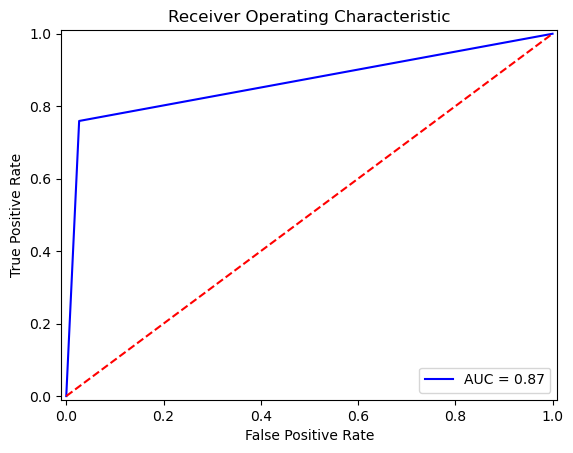

_____________________________________________________________________________________________


In [60]:
clf = svm.SVC()
clf.fit(X_train_svm, y_train_svm)

svm_y_pred = clf.predict(X_test_svm)

svm_acc=round(accuracy_score(y_test_svm,svm_y_pred)*100,2)
svm_pre=round(precision_score(y_test_svm,svm_y_pred)*100,2)
svm_rec=round(recall_score(y_test_svm,svm_y_pred)*100,2)
svm_f1=round(f1_score(y_test_svm,svm_y_pred)*100,2)

print('_____________________________________________________________________________________________')
print('SUPPORT VECTOR MACHINE :\n')
print('_____________________________________________________________________________________________')
print('The Accuracy score is: ',round(accuracy_score(y_test_svm,svm_y_pred)*100,2))
print('The Precision score is: ',round(precision_score(y_test_svm,svm_y_pred)*100,2))
print('The Recall score is: ',round(recall_score(y_test_svm,svm_y_pred)*100,2))
print('The F1 score is: ',round(f1_score(y_test_svm,svm_y_pred)*100,2))
print('\nThe confusion matrix :\n',confusion_matrix(y_test_svm,svm_y_pred))

f, ax =plt.subplots(figsize = (3,3))

sns.heatmap(confusion_matrix(y_test_svm,svm_y_pred),annot = True, linewidths= 0.5, linecolor="blue", fmt=".0f", ax=ax)
ax.xaxis.set_ticklabels(['Not Fraud', 'Fraud']); ax.yaxis.set_ticklabels(['Not Fraud', 'Fraud']);
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print('\nThe ROC curve is :')
plot_roc_curve(y_test_svm,svm_y_pred)
print('_____________________________________________________________________________________________')

## COMPARISON OF ALL THE MODELS

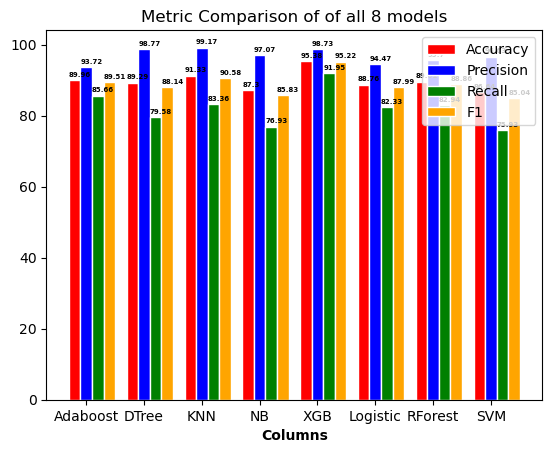

In [61]:
x_labels = ['Adaboost', 'DTree', 'KNN', 'NB', 'XGB', 'Logistic', 'RForest', 'SVM']
accuracy = [round(accuracy_score(y_test,adab_pred)*100,2), round(accuracy_score(y_test,dtree_pred)*100,2),round(accuracy_score(y_test,knn_pred)*100,2),round(accuracy_score(y_test,gnb_pred)*100,2),round(accuracy_score(y_test,xgb_y_pred)*100,2),round(accuracy_score(y_test,lr_y_pred)*100,2),round(accuracy_score(y_test,rlf_y_pred)*100,2),svm_acc]
precision = [round(precision_score(y_test,adab_pred)*100,2), round(precision_score(y_test,dtree_pred)*100,2),round(precision_score(y_test,knn_pred)*100,2),round(precision_score(y_test,gnb_pred)*100,2),round(precision_score(y_test,xgb_y_pred)*100,2),round(precision_score(y_test,lr_y_pred)*100,2),round(precision_score(y_test,rlf_y_pred)*100,2),svm_pre]
recall = [round(recall_score(y_test,adab_pred)*100,2),round(recall_score(y_test,dtree_pred)*100,2),round(recall_score(y_test,knn_pred)*100,2),round(recall_score(y_test,gnb_pred)*100,2),round(recall_score(y_test,xgb_y_pred)*100,2),round(recall_score(y_test,lr_y_pred)*100,2),round(recall_score(y_test,rlf_y_pred)*100,2),svm_rec]
f1score = [round(f1_score(y_test,adab_pred)*100,2), round(f1_score(y_test,dtree_pred)*100,2),round(f1_score(y_test,knn_pred)*100,2),round(f1_score(y_test,gnb_pred)*100,2),round(f1_score(y_test,xgb_y_pred)*100,2),round(f1_score(y_test,lr_y_pred)*100,2),round(f1_score(y_test,rlf_y_pred)*100,2),svm_f1]

barWidth = 0.2


r1 = np.arange(len(accuracy))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

plt.bar(r1, accuracy, color='red', width=barWidth, edgecolor='white', label='Accuracy')
plt.bar(r2, precision, color='blue', width=barWidth, edgecolor='white', label='Precision')
plt.bar(r3, recall, color='green', width=barWidth, edgecolor='white', label='Recall')
plt.bar(r4, f1score, color='orange', width=barWidth, edgecolor='white', label='F1')

for i, v in enumerate(accuracy):
    plt.text(i - barWidth/2, v + 1, str(v), color='black', fontweight='bold',fontsize=5)
for i, v in enumerate(precision):
    plt.text(i + barWidth/2, v + 1, str(v), color='black', fontweight='bold',fontsize=5)
for i, v in enumerate(recall):
    plt.text(i + 3*barWidth/2, v + 1, str(v), color='black', fontweight='bold',fontsize=5)
for i, v in enumerate(f1score):
    plt.text(i + 5*barWidth/2, v + 1, str(v), color='black', fontweight='bold',fontsize=5)


plt.xlabel('Columns', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(accuracy))], x_labels)
plt.title('Metric Comparison of of all 8 models')

plt.legend()

plt.show()

In [62]:
classifiers = [GaussianNB(), 
               KNeighborsClassifier(n_neighbors= 1),
               AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators=10),
               LogisticRegression(random_state=42),
               DecisionTreeClassifier(random_state=42),
               RandomForestClassifier(random_state=42),
               xgb.XGBClassifier(objective="binary:logistic", random_state=42)
              ]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(X_train, y_train)
    yproba = model.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

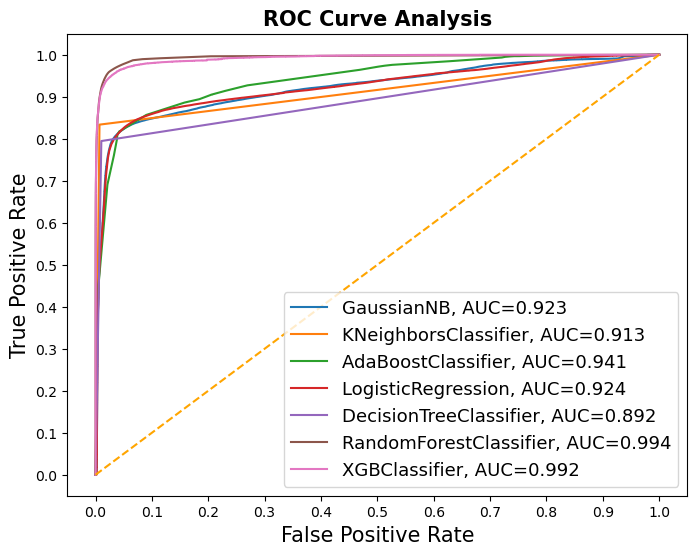

In [63]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

## --------------------------------------------------------------------------------------------------------------------------